# Prevendo valores de ações com algoritmos de Machine Learning e Deep Learning

O Objetivo desta aula é realizarmos 4 tipos de testes de predição de séries temporais!

Vamos utilizar desde modelos mais tradicionais como a **média móvel** e o **ARIMA**, até modelos mais robustos como o **Prophet** do Facebook (Meta) e ainda a _deep learning_ **LSTM**.

## Sobre o dataset

O _dataset_ é composto pelo histórico do valor das ações da **Disney** no período de 01/01/2018 até 15/02/2024

-> Link para acessar os dados do Yahoo Finanças: https://br.financas.yahoo.com/quote/%5EBVSP/history?period1=1514764800&period2=1707955200&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

In [5]:
# Bibliotecas básicas de Data Science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline

# Para baixar os dados
import yfinance as yf

# Para aplicar o ARIMA:
from statsmodels.tsa.stattools import adfuller # verificar dados estacionários
from statsmodels.tsa.stattools import acf, pacf # correlação
from statsmodels.tsa.seasonal import seasonal_decompose # decomposição sazonal usando médias móveis
from statsmodels.tsa.arima.model import ARIMA # algoritmo arima

# Para Deep Learning
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator

# Para Machine Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Prophet
from prophet import Prophet

## Upload do dataframe

In [12]:
import yfinance as yf

# Especifique o símbolo da Disney (DIS) e o intervalo de datas desejado
symbol = '^BVSP'
start_date = '2018-01-01'
end_date = '2024-02-15'

# Use a função download para obter os dados
df = yf.download(symbol, start = start_date, end = end_date)

[*********************100%%**********************]  1 of 1 completed


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1516 entries, 0 to 1515
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1516 non-null   datetime64[ns]
 1   Open       1516 non-null   float64       
 2   High       1516 non-null   float64       
 3   Low        1516 non-null   float64       
 4   Close      1516 non-null   float64       
 5   Adj Close  1516 non-null   float64       
 6   Volume     1516 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 83.0 KB


In [23]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,76403.0,77909.0,76403.0,77891.0,77891.0,2880300
1,2018-01-03,77889.0,78414.0,77602.0,77995.0,77995.0,3142200
2,2018-01-04,77998.0,79135.0,77998.0,78647.0,78647.0,3486100
3,2018-01-05,78644.0,79071.0,78218.0,79071.0,79071.0,2747100
4,2018-01-08,79070.0,79395.0,78631.0,79379.0,79379.0,2550800


In [24]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1511,2024-02-06,127593.0,130417.0,127593.0,130416.0,130416.0,13780300
1512,2024-02-07,130412.0,130552.0,129518.0,129608.0,129608.0,15425400
1513,2024-02-08,129950.0,130126.0,127912.0,128217.0,128217.0,13634900
1514,2024-02-09,128216.0,128896.0,127579.0,128026.0,128026.0,12115800
1515,2024-02-14,128026.0,128026.0,126663.0,127018.0,127018.0,7748300


In [26]:
df.shape

(1516, 7)

In [27]:
# cria uma cópia do df original
df_ibovespa = df

## Visualizando os valores de fechamento

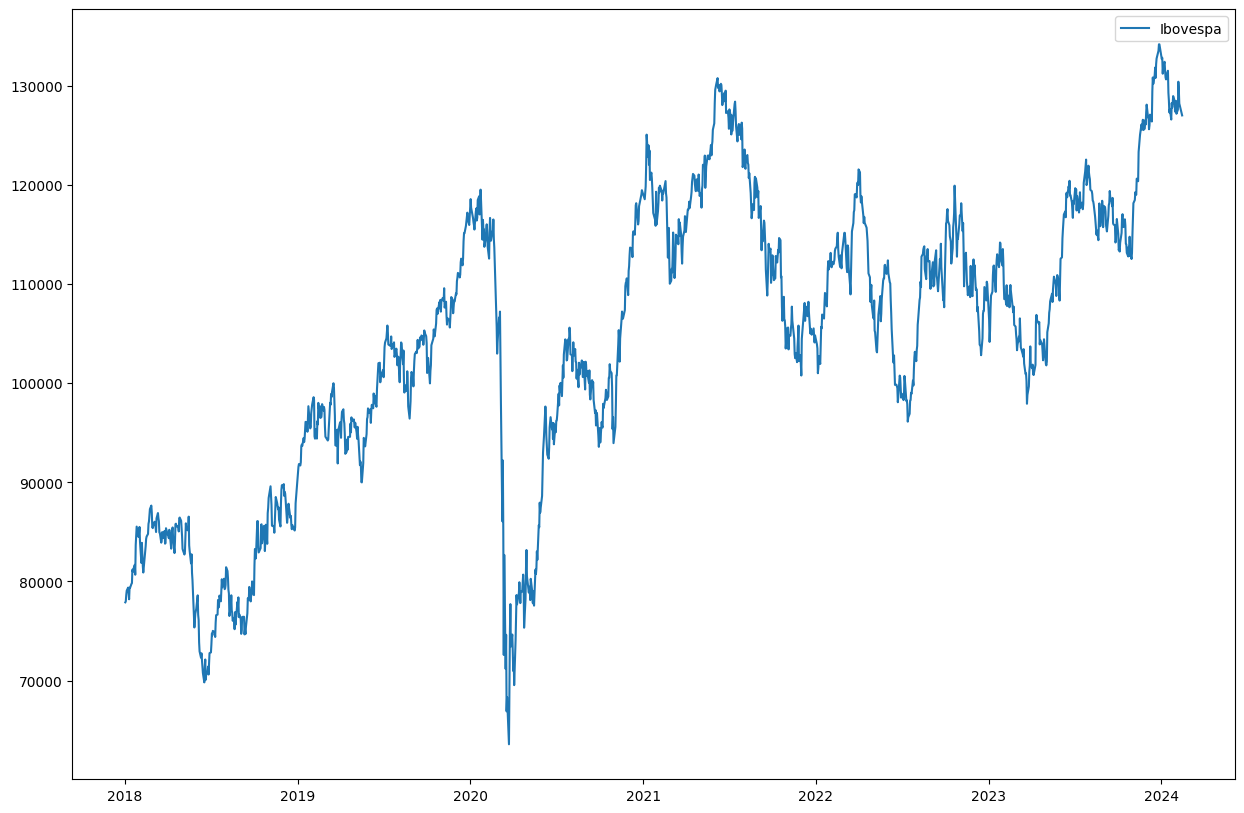

In [28]:
plt.figure(figsize = (15, 10))
plt.plot(df['Date'], df['Close'], label = 'Ibovespa')

plt.legend(loc='best')
plt.show()

- A base da Ibovespa, não é composta por um conjunto de dados estacionários. Uma base estacionária apresenta um padrão de comportamento ao longo do tempo, permitindo que os modelos de predição trabalhem com correlações para trazer o resultado de predição. Para que seja possível rodar modelos como SARIMA, é necessário tentar tornar a base estacionária. Se mesmo depois de fazer isso, o modelo não funcionar, aí é indicado o uso de modelos mais poderosos, por exemplo, o Prophet.

### Análise do gráfico acima

- 2018 foi marcado pela queda na expectativa de crescimento do país, logo nos primeiros meses do ano. 5 fatos importantes marcaram a economia do brasileira em 2018:
    1. Em março, os EUA impuseram sobretaxa no aço dando início a uma guerra comercial,
    2. Em maio, inciou-se a maior greve de caminhoneiros já registrada no país,
    3. Também em maio, para controlar e reverter a situação, o Governo Federal, anunciou o **subsídio ao diesel** como forma de interromper a greve,
    4. Em Agosto, começa o período de campanha eleitoral para Presidência,
    4. Em Outubro, o país ele Jair Bolsonaro para presidente.

- 2019 iniciou com um mercado otimista. A promessa de reformas, queda no desemprego, retomada dos investimentos e o crescimento, foram os aspectos que puxaram esse otimismo que, no decorrer dos meses, foi se dissipando com a demora na espera da aprovação da reforma da Previdência, aliada à escândalos políticos que se multiplicaram no cenário econômico.

- 2020 foi o ano que todas as previsões não se cumpriram. A grande crise global puxada pela Pandemia do Corona Vírus fez com que todas as previsões e expectativas caíssem por terra logo nos primeiros meses do ano. Além da crise humanitária, a economia precisou enfrentar alta taxa de desemprego, paralisação de grande parte dos serviços e comércio. Os dois setores que mais empregam no país, foi o responsável por puxar a taxa de desemprego para cima, tornando a economia um verdadeiro campo minado.

- 2021 foi o ano de turbilhão na economia. Diversas crises institucionais, tentativa de mudanças nas regras de contas públicas, idas e vindas de programas de auxílio... tudo isso dentro de um contexto "pós-pandêmico" em que a crise do COVID-19 ainda não fazia parte de um passado longíquo. Muitos setores da economia já davam os seus primeiros passos para a retomada mas, ainda estávamos muito longe de um cenário de normalização.

- 2022 foi marcado pela retomada de crescimento econômico do país. Mas, junto com ele, vimos o retorno da inflação e o crescimento do emprego, mesmo que de forma precária. A aspecto importante aqui é: não foi só o Brasil que sofreu com a inflação. Este mal ganhou ares globai, atingindo a maior parte das economias do mundo, inclusive as desenvolvidas. Nesta conta, podemos colocar os ainda presentes desdobramentos da Pandemia, a guerra na Ucrânia (que trouxe entraves econômicos entre a Russia e, praticamente o resto do mundo) e as medidas radicais do governo Chinês para contenção da Covid que acabou paralisando parte da produção da segunda maior economia do mundo. Tudo isso, aliado à eleição que trouxe de volta Lula a cadeira de Presidente do Brasil, colaborou para que a economia encerrase o ano cercada de incertezas.

- 2023 começou com muitas incertezas. Todos os desdobramentos de 2022, incluindo a troca do cargo mais alto da nação, fizeram com que o Mercado se tornasse mais desconfiado sobre o que aconteceria no decorrer do ano. O Brasil terminou o ano como a 9ª maior economia do mundo (voltando a figuras na lista das 10 economias de maior impacto global). Não é pouco, especialmente se considerarmos o retrospecto dos últimos anos, cercados de incertezas, recheado por uma Pandemia e duas guerras: Ucrânia x Russia e Israel x Hamas. O setor agrícola brasileiro, sem dúvidas, foi um dos principais impulsionadores da economia, respondendo por 24,4% do PIB brasileiro em 2023.

- Para 2024, as expectativas são positivas. A previsão de crescimento do PIB, é de 2% impulsionado especialmente pela geração de emprego e por investimentos.

## Análise de série temporal (Decomposição)


Dentro das etapas de análise de uma série tempora, existe a etapa da realização de sua decomposição. Decompor uma série tempora significa analisar:

- Tendência
- Sazonalidade
- Ruído

Iremos utilizar o **Startsmodel** para decompor nossos dados e visualizar vários gráficos. Utilizar a decomposição dos dados da série pode **auxiliar na compreensão dos dados e na tomada de decisão de qual modelo preditivo utilizar**.

Ao compreender a tendência, podemos fazer previsões de longo prazo.

Ao entender a sazonalidade, podemos prever padrões de curto prazo.

E ao analisar os resíduos, podemos entender o que não foi capturado pelos dois primeiros componentes e, assim, melhorar os modelos.

### O que é tendência?

**Direcionamento** de sua série temporal (para qual direção ela está indo).

### O que é Sazonalidade?

Encontrar **características e padrões no tempo** que podem aparecer de forma repetida.

### O que é o ruído?

Após extrair a tendência e a sazonalidade da série original, o que resta é chamado de resíduo. Os resíduos são a **diferença entre a série original e o que foi explicado pela tendência e a sazonalidade**.

### Série aditiva ou mutiplicativa

A decomposição pode ajudar a identificar se uma série temporal é **aditiva ou multiplicativa**. Uma série é considerada **aditiva** quando a **magnitude da sazonalidade e da tendência não varia com o tempo**. Por outro lado, em uma série **multiplicativa**, a **magnitude da sazonalidade ou da tendência varia em proporção ao nível da série**.

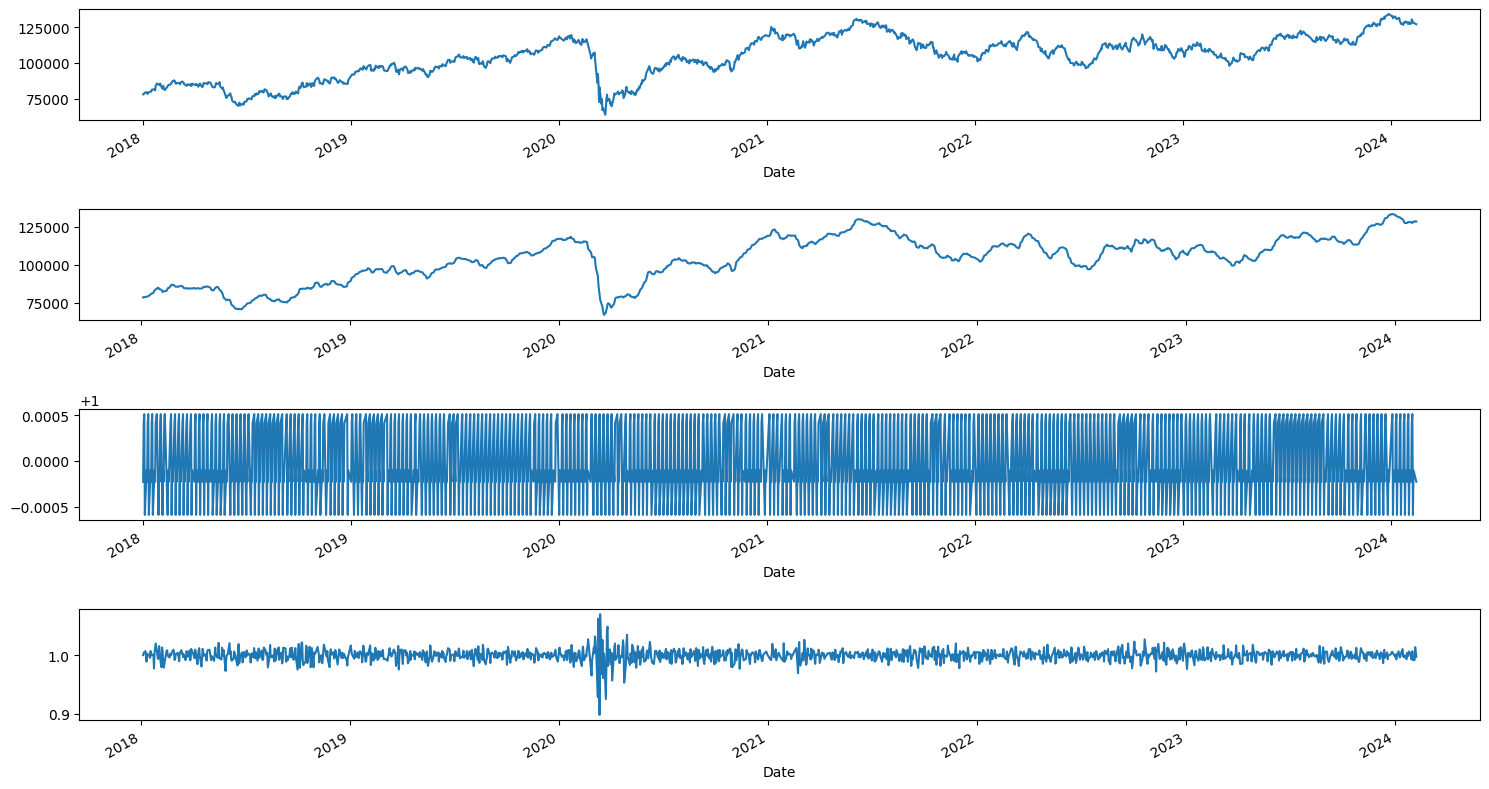

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

df_limpo = df                                                                # cópia do dataframe
df_limpo['Date'] = pd.to_datetime(df_limpo['Date'])                          # transforma a coluna de data em datetime
df_limpo = df.drop(columns = ['Open', 'High', 'Low', 'Volume', 'Adj Close']) # remove as colunas que não serão utilizadas
df_limpo = df_limpo.set_index('Date')                                        # define a coluna data como índice

seasonplot = seasonal_decompose(df_limpo, model = 'multiplicative', period = 5) # decompondo a série temporal
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (15, 8))
seasonplot.observed.plot(ax = ax1) # série real
seasonplot.trend.plot(ax = ax2)    # tendência
seasonplot.seasonal.plot(ax = ax3) # sazonalidade
seasonplot.resid.plot(ax = ax4)    # resíduos
plt.tight_layout()

#### Notas da análise de decomposição da série

- `model = 'addtive`: este parâmetro especifica o tipo de modelo utilizado na decomposição. Os dois principais tipos são:
    1. `additive`: modelo apropriado quando a magnitude a sazonalidade não varia com a tendência.
    2. `multiplicative`: modelo é mais apropriado quando a magnitude da sazonalidade varia com a tendência.
- Sobre o resultado dos gráficos: mostra uma base **não estacionária** com muito ruído e oscilação.

37 minutos